# Import Libray

In [1]:
import pandas as pd
import numpy as np
from pyMetaheuristic.algorithm import ant_lion_optimizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE, RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import pickle
import time


# Function for create table visualization

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

def visualize_classification_reports(reports_dict, title=None, save_path=None):
    # Create an empty list to store the metrics for each report
    metrics_list = []
    
    # Loop through the reports and extract the metrics
    for label, report in reports_dict.items():
        report_dict = report
        metrics = [label,
                   report_dict['accuracy'],
                   report_dict['macro avg']['precision'],
                   report_dict['macro avg']['recall'],
                   report_dict['macro avg']['f1-score']]
        metrics_list.append(metrics)
    
    # Create a pandas dataframe from the metrics list
    headers = ['Label', 'Accuracy', 'Precision', 'Recall', 'F1-score']
    df = pd.DataFrame(metrics_list, columns=headers)
    
    # Set the label column as the index
    df.set_index('Label', inplace=True)
    
    # Format the values to two decimal places
    df = df.round(2)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.axis('off')
    ax.axis('tight')
    ax.set_title(title, fontsize=16, fontweight='bold')
    table = ax.table(cellText=df.values,
                     colLabels=df.columns,
                     rowLabels=df.index,
                     cellLoc='center',
                     loc='center')
 
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    table.scale(1, 2)
    
    print(df)

    # Save the table as a PNG image if a save path is specified
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
        plt.close()

    # Return the styled dataframe
    return table


In [3]:
with open('resesi_38k.pkl', 'rb') as file:
    data = pickle.load(file)

In [25]:
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import classification_report

param_grid_bernoulli_multinomial = {
    'alpha': [0.1, 0.5, 1, 5, 10],
    'fit_prior': [True, False]
}

param_grid_gaussian = {
    'priors': [None, [0.2, 0.3, 0.5], [0.1, 0.1, 0.8]],
    "var_smoothing": [1e-9, 1e-8, 1e-7]
}

def find_best_model(datasets, param_grid_bernoulli_multinomial=param_grid_bernoulli_multinomial,
                    param_grid_gaussian=param_grid_gaussian):
    '''
    Generate datasets into classification reports object
    
    Parameters:
    datasets: object of dataset consist of (X_train, y_train, X_test, y_test)
    param_grid_bernoulli_multinomial: parameters for BernoulliNB and MultinomialNB grid search
    param_grid_gaussian: parameters for GaussianNB grid search

    Returns:
    Object of classification reports
    '''

    results = {}

    for dataset, (X_train, X_test, y_train, y_test) in datasets.items():
        models = {
            'BernoulliNB': BernoulliNB(),
            'MultinomialNB': MultinomialNB(),
            'GaussianNB': GaussianNB()
        }

        for model_name, model in models.items():
            if model_name in ['BernoulliNB', 'MultinomialNB']:
                param_grid = param_grid_bernoulli_multinomial
            else:
                param_grid = param_grid_gaussian

            grid_search = GridSearchCV(model, param_grid, cv=5)
            #start_time = time.time()

            grid_search.fit(X_train.toarray(), y_train)

            best_model = model.set_params(**grid_search.best_params_)
            best_model.fit(X_train.toarray(), y_train)
            y_pred = best_model.predict(X_test.toarray())
            class_report = classification_report(y_test, y_pred, zero_division=False, output_dict=True)
            #end_time = time.time()

            execution_time = grid_search.cv_results_['mean_fit_time'][grid_search.best_index_]
            class_report['Time Exct'] = execution_time
            #execution_time = end_time - start_time

            print(f"{dataset} - {model_name} Classification Report \n {class_report}")
            print(f"Execution time for {model_name}: {execution_time} seconds\n")
            #print(runtime = model.cv_results_['mean_fit_time'][model.best_index_])
            results[f"{dataset} - {model_name}"] = class_report

    return results

In [5]:
datasets = {}

for sampler, steps in data.items():
    for step, labels in steps.items():
        
        if type(labels) is dict:
            for label, data in labels.items():
                datasets[f'{label}_{sampler}_{step}'] = data
        else:
            datasets[f'{step}_{sampler}'] = labels

In [6]:
all_reports = find_best_model(datasets, param_grid_bernoulli_multinomial, param_grid_gaussian)

Vader_Normal - BernoulliNB Classification Report 
 {'negative': {'precision': 0.803514799154334, 'recall': 0.9055845122859271, 'f1-score': 0.8515017853392144, 'support': 6715}, 'neutral': {'precision': 0.13548387096774195, 'recall': 0.07706422018348624, 'f1-score': 0.09824561403508773, 'support': 545}, 'positive': {'precision': 0.655150351887396, 'recall': 0.4695093993580926, 'f1-score': 0.5470085470085471, 'support': 2181}, 'accuracy': 0.7570172651202203, 'macro avg': {'precision': 0.5313830073364906, 'recall': 0.4840527106091686, 'f1-score': 0.4989186487942831, 'support': 9441}, 'weighted avg': {'precision': 0.7306772061715054, 'recall': 0.7570172651202203, 'f1-score': 0.7376765161770563, 'support': 9441}}
Execution time for BernoulliNB: 15.978237867355347 seconds

Vader_Normal - MultinomialNB Classification Report 
 {'negative': {'precision': 0.7848195460746621, 'recall': 0.942367833209233, 'f1-score': 0.8564081743131682, 'support': 6715}, 'neutral': {'precision': 0.1575757575757575

                                                   Accuracy  Precision   
Label                                                                    
Vader_Normal - BernoulliNB                             0.76       0.53  \
Vader_Normal - MultinomialNB                           0.76       0.55   
Vader_Normal - GaussianNB                              0.34       0.38   
TextBlob_Normal - BernoulliNB                          0.69       0.66   
TextBlob_Normal - MultinomialNB                        0.69       0.67   
TextBlob_Normal - GaussianNB                           0.34       0.46   
Vader_RandomOversampler_Before - BernoulliNB           0.79       0.79   
Vader_RandomOversampler_Before - MultinomialNB         0.81       0.81   
Vader_RandomOversampler_Before - GaussianNB            0.64       0.73   
TextBlob_RandomOversampler_Before - BernoulliNB        0.72       0.72   
TextBlob_RandomOversampler_Before - MultinomialNB      0.72       0.73   
TextBlob_RandomOversampler_Before - Ga

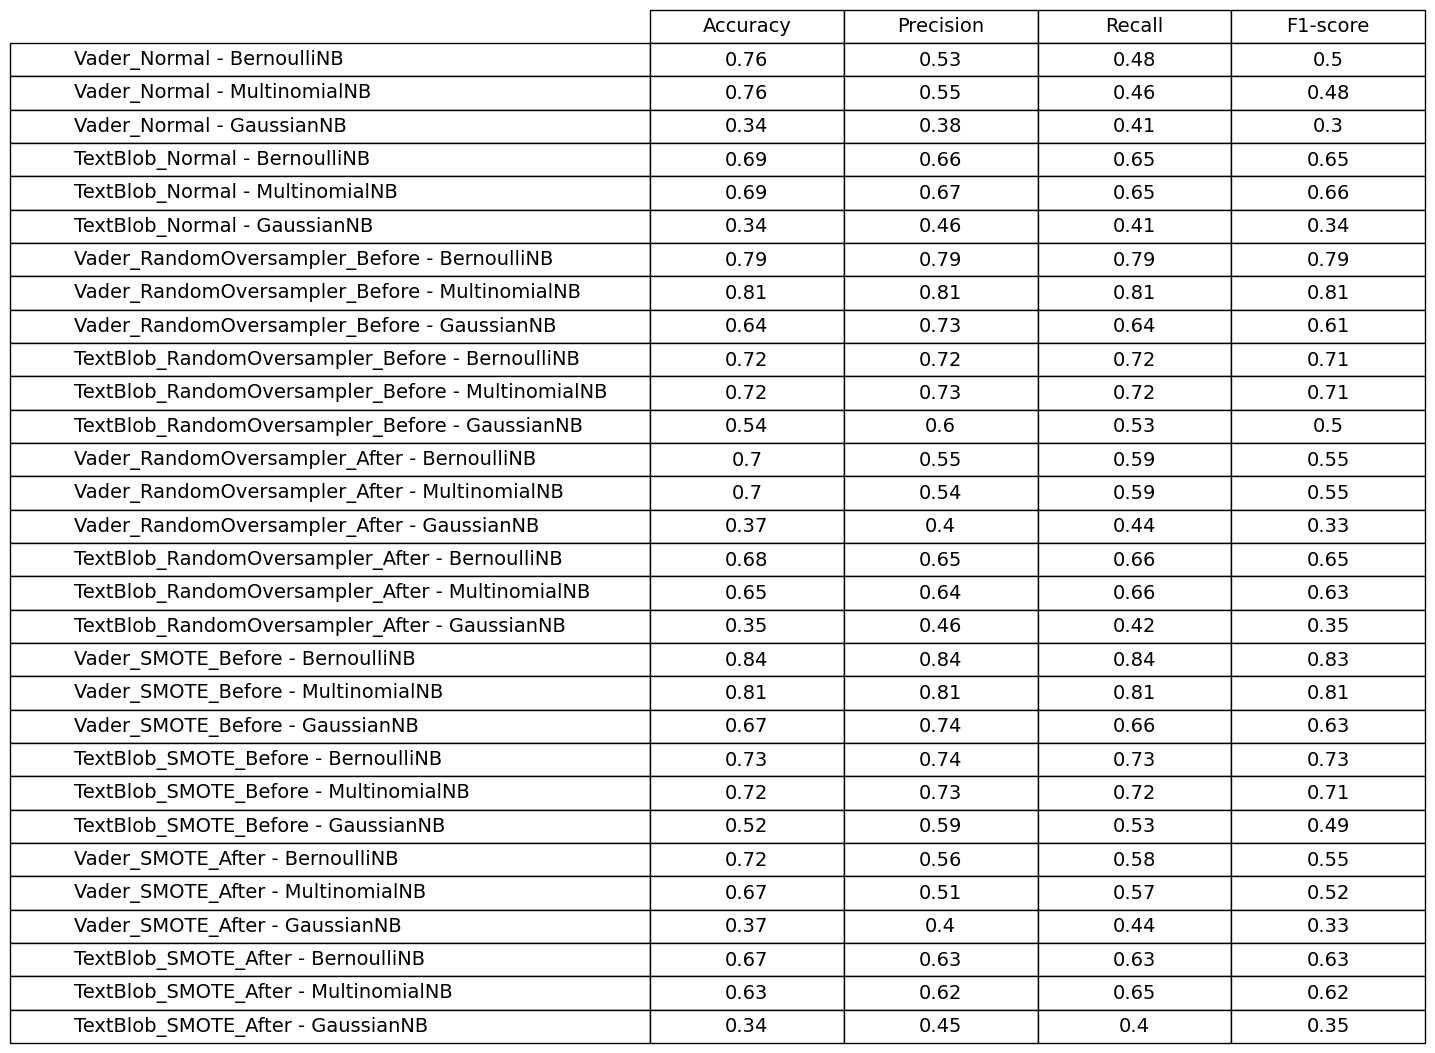

In [30]:
visualize_classification_reports(all_reports)